# Install detectron

In [ ]:
!gcc --version

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
!pip install torch==1.7.1 torchvision==0.8.2
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.7")   # need to manually install torch 1.7 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 14.2 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=22c612071bdec13fa913db90129de662b7af327aa09ce5d35c444df7f050dc6e
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.8 MB 16 kB/s 
     |████████████████████████████████| 12.8 MB 66.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting unin

In [ ]:
# Some basic setup:
import torch, torchvision
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import os, json, cv2, random, imutils
from matplotlib import pyplot as plt
from scipy import stats as st
from PIL import Image
from google.colab import drive
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg, CfgNode
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import _create_text_labels, GenericMask
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode


# Prepare the dataset

In [ ]:
# download the dataset from drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
register_coco_instances("train_corals", {}, "/content/drive/MyDrive/Coral_dataset/json_annotation_train.json", "/content/drive/MyDrive/Coral_dataset/Train")
register_coco_instances("Val_corals", {}, "/content/drive/MyDrive/Coral_dataset/json_annotation_val.json", "/content/drive/MyDrive/Coral_dataset/Val")

In [ ]:
dataset_dicts = DatasetCatalog.get("Val_corals")

[06/22 14:31:13 d2.data.datasets.coco]: Loaded 65 images in COCO format from /content/drive/MyDrive/Coral_dataset/json_annotation_val.json


In [ ]:
MetadataCatalog.get("Val_corals").thing_colors = [(230, 230, 230)]
corals_metadata = MetadataCatalog.get("Val_corals")

# Load the model

In [ ]:
model_path = "/content/drive/MyDrive/DSTI/coral_reef/model_final.pth"

In [ ]:
cfg = get_cfg()
config_file="COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_file))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)  # initialize weights from model zoo
cfg.MODEL.WEIGHTS = model_path

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold

predictor = DefaultPredictor(cfg)

### Just to verify the images are correctly loaded and the model works

In [ ]:
# Custom Visualizer class
class Visualizer_custom(Visualizer):
  def __init__(self, img_rgb, metadata=None, scale=1.0, instance_mode=ColorMode.SEGMENTATION):
    super().__init__(img_rgb, metadata, scale, instance_mode)

  def draw_instance_predictions(self, predictions):
        """
        Draw instance-level prediction results on an image.

        Args:
            predictions (Instances): the output of an instance detection/segmentation
                model. Following fields will be used to draw:
                "pred_boxes", "pred_classes", "scores", "pred_masks" (or "pred_masks_rle").

        Returns:
            output (VisImage): image object with visualizations.
        """
        boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
        scores = predictions.scores if predictions.has("scores") else None
        classes = predictions.pred_classes.tolist() if predictions.has("pred_classes") else None
        labels = _create_text_labels(classes, scores, self.metadata.get("thing_classes", None))
        keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

        if predictions.has("pred_masks"):
            masks = np.asarray(predictions.pred_masks)
            masks = [GenericMask(x, self.output.height, self.output.width) for x in masks]
        else:
            masks = None

        if self._instance_mode == ColorMode.SEGMENTATION and self.metadata.get("thing_colors"):
            colors = [
                [x / 255 for x in self.metadata.thing_colors[c]] for c in classes
            ]
            alpha = 0.8
        else:
            colors = None
            alpha = 0.5

        if self._instance_mode == ColorMode.IMAGE_BW:
            self.output.reset_image(
                self._create_grayscale_image(
                    (predictions.pred_masks.any(dim=0) > 0).numpy()
                    if predictions.has("pred_masks")
                    else None
                )
            )
            alpha = 0.3

        self.overlay_instances(
            masks=masks,
            boxes=boxes,
            labels=labels,
            keypoints=keypoints,
            assigned_colors=colors,
            alpha=alpha,
        )
        return self.output

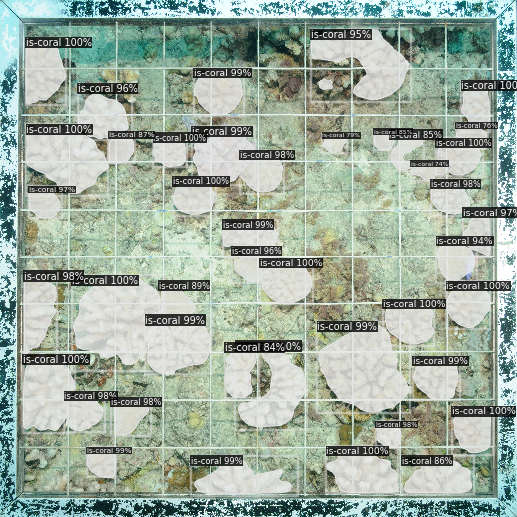

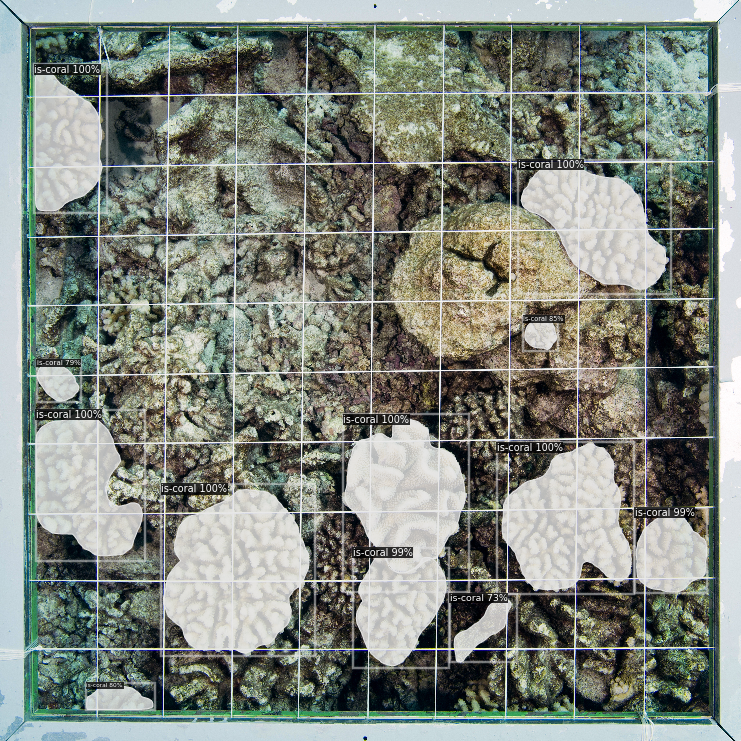

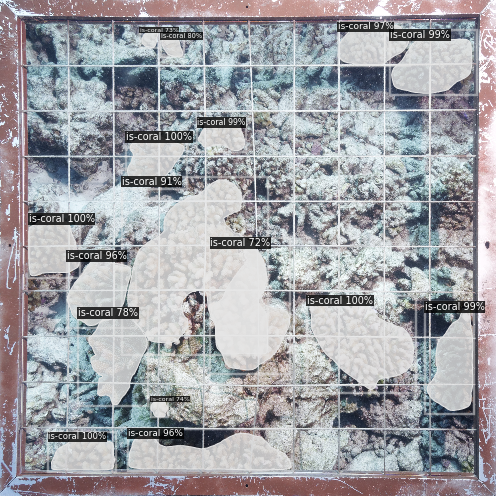

In [ ]:
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  
    v = Visualizer_custom(im[:, :, ::-1],
                   metadata = corals_metadata,
                   instance_mode=ColorMode.SEGMENTATION,
                   scale=0.2)
    
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

# Analysis

In [ ]:
pred_count = [None]*len(dataset_dicts) # number of corals found in each images
pred_area = [None]*len(dataset_dicts) # total area of predicted corals in each images
true_area = [None]*len(dataset_dicts) # real total area of corals in each images

error_with_none = [None]*len(dataset_dicts) # prediction error

result = [] # a dictionary with the analysis outputs (file_name, pred_area, pred_count, error, etc)

count = 0
for d in dataset_dicts:  

    img = cv2.imread(d["file_name"])
    outputs = predictor(img) 

    mask_array = 1*outputs["instances"].get('pred_masks').to('cpu').numpy()
    mask_array = np.moveaxis(mask_array, 0, -1)

    # Evaluate coverage from model prediction
    coverage = [None]*mask_array.shape[2]
    for object in range(mask_array.shape[2]):
        mask = mask_array[:,:,object]
        coverage[object] = mask.sum()

    pred_area[count] = 100*sum(coverage)/(mask_array.shape[0]*mask_array.shape[1])
    pred_count[count] = len(coverage)

    # Find true coverage
    coverage = [None]*len(d["annotations"])
    for object in range(len(d["annotations"])):
        segm = d["annotations"][object]["segmentation"][0]
        cnt = np.array([[[int(segm[i]), int(segm[i+1])]] for i in range(0,len(segm),2)])
        coverage[object] = cv2.contourArea(cnt)
    
    true_area[count] = 100*sum(coverage)/(mask_array.shape[0]*mask_array.shape[1])

    # Compute the error
    if true_area[count] != 0:
        error_with_none[count] = 100*(pred_area[count]-true_area[count])/true_area[count]

    # Result dictionary
    head_tail = os.path.split(d['file_name'])

    result.append({"file_name": head_tail[1], 
                   "image_id": d["image_id"],
                 "corals_count": len(d["annotations"]),
                 "pred_corals_count": pred_count[count],
                 "coverage": true_area[count], 
                 "pred_coverage": pred_area[count],
                 "coverage_error": error_with_none[count]
                 })

    # Print
    print(f"Image {count+1}: {head_tail[1][:-4]} - Error: {error_with_none[count]}")
    count += 1

Image 1: E2B_01_2010 - Error: None
Image 2: E2B_02_2012 - Error: -91.49144964143657
Image 3: E2B_02_2020 - Error: -7.300489978755115
Image 4: E2B_03_2008 - Error: None
Image 5: E2B_03_2016 - Error: -16.613482461733717
Image 6: E2B_03_2018 - Error: -7.541625585172786
Image 7: E2B_05_2006 - Error: -6.975901103948015
Image 8: E2B_05_2008 - Error: None
Image 9: E2B_05_2010 - Error: None
Image 10: E2B_05_2014 - Error: -17.731418238602448
Image 11: E2B_06_2008 - Error: None
Image 12: E2B_07_2014 - Error: -3.0193084649317488
Image 13: E2B_07_2016 - Error: -14.404003290539809
Image 14: E2B_07_2020 - Error: 0.49673332728836733
Image 15: E2B_08_2008 - Error: 507.3847409220726
Image 16: E2B_08_2016 - Error: -6.168133773633594
Image 17: E2B_09_2006 - Error: 13.207295810558643
Image 18: E2B_09_2008 - Error: None
Image 19: E2B_15_2018 - Error: -7.902642691457979
Image 20: E2B_16_2018 - Error: -10.145323704859043
Image 21: Haapiti_01_2010 - Error: 0.4219937416182375
Image 22: Haapiti_02_2006 - Error:

Remark: 
* If there is no coral on the image (image 1 for example), the coverage is null so we cannot compute the error (None values)

In [ ]:
# Remove None values
error = pd.Series([t for t in error_with_none if t is not None])

In [ ]:
error.describe()

count     51.000000
mean       8.259953
std       80.623417
min      -91.491450
25%      -10.177007
50%       -3.019308
75%        1.778155
max      507.384741
dtype: float64

In [ ]:
#create 95% confidence interval for population mean weight
CI = st.t.interval(alpha=0.95, df=len(error)-1, loc=np.mean(error), scale=st.sem(error))
CI 

(-14.415748091128108, 30.93565480297559)

In [ ]:
8.259953-(-14.415748091128108)

22.675701091128108

In [ ]:
30.93565480297559-(8.259953)

22.675701802975592

Conclusion: error = 8.26 +- 22.67

Text(0, 0.5, 'Count')

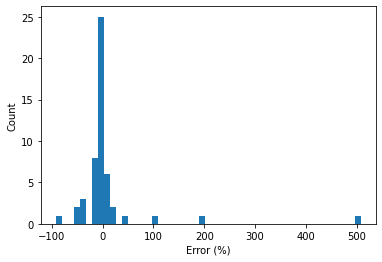

In [ ]:
plt.hist(x = error, bins = len(error))
plt.xlabel('Error (%)')
plt.ylabel('Count')

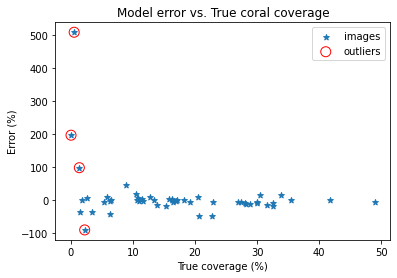

In [ ]:
outliers = [i if i is not None and abs(i) > 80 else None for i in error_with_none]
plt.scatter(true_area, error_with_none, marker='*', label='images')
plt.scatter(true_area, outliers, color='r', s=100, facecolors='none', label='outliers')
plt.ylabel("Error (%)")
plt.xlabel("True coverage (%)")
plt.title("Model error vs. True coral coverage")
plt.legend()

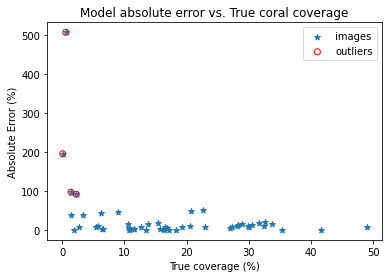

In [ ]:
abs_error = [abs(i) if i is not None else None for i in error_with_none]
outliers = [abs(i) if i is not None and abs(i) > 80 else None for i in error_with_none]
plt.scatter(true_area, abs_error, marker='*', label='images')
plt.scatter(true_area, outliers, color='r', facecolors='none', label='outliers')
plt.ylabel("Absolute Error (%)")
plt.xlabel("True coverage (%)")
plt.title("Model absolute error vs. True coral coverage")
plt.legend()

The outliers (red circles) are probably due to the fact that:
* the real coverage is very close to 0 (and division by something close to 0 gives a very high error)

When the corals area is high enough, the model error stays smaller

In [ ]:
# List all the images that have an error higher than 80%
for image in result:
  if image["coverage_error"] is not None and abs(image["coverage_error"]) > 80:
    print(image["file_name"], image["coverage_error"])

E2B_02_2012.jpg -91.49144964143657
E2B_08_2008.jpg 507.3847409220726
Haapiti_11_2008.jpg 96.999703674437
Tubuai_13_2015.jpg 195.48829240434037


(-100.0, 100.0)

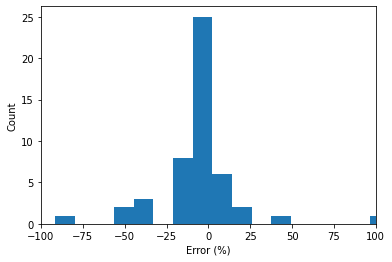

In [ ]:
plt.hist(x = error, bins = len(error))
plt.xlabel('Error (%)')
plt.ylabel('Count')
plt.xlim(-100,100)

In [ ]:
# Remove outliers
threshold = 80
error_bis = pd.Series([err for err in error if err < threshold])

In [ ]:
error_bis.describe()

count    48.000000
mean     -7.887815
std      20.852063
min     -91.491450
25%     -10.637273
50%      -3.926348
75%       0.705120
max      45.366257
dtype: float64

In [ ]:
CI = st.t.interval(alpha=0.95, df=len(error_bis)-1, loc=np.mean(error_bis), scale=st.sem(error_bis))
CI 

(-13.94262293741762, -1.8330068896131788)

In [ ]:
-7.887815-(-13.94262293741762)

6.054807937417619

In [ ]:
-1.8330068896131788-(-7.887815)

6.054808110386821

**Conclusion:** error = -7.889 +- 6.0548

### Normality test

In [ ]:
st.normaltest(error)

NormaltestResult(statistic=91.04090103794702, pvalue=1.7010595828102523e-20)

In [ ]:
st.normaltest(error_bis)

NormaltestResult(statistic=26.513338896541256, pvalue=1.748644838051901e-06)

### Wilcoxon test: To test the null hypothesis that the mean error is null

In [ ]:
#st.ttest_1samp(error, popmean=0)

Ttest_1sampResult(statistic=0.7316468069401363, pvalue=0.46779959468718735)

In [ ]:
#st.ttest_1samp(error_bis, popmean=0)

Ttest_1sampResult(statistic=-2.6207662964724245, pvalue=0.011780626127305476)

In [ ]:
st.wilcoxon(error)

WilcoxonResult(statistic=472.0, pvalue=0.07340052726597435)

- We reject the hypothesis that the mean error is null (but almost, p = 0.07 > 5%)
- In average, the model underestimates the coverage by 7.887815% (if we don't take into account the outliers) // Error = -7.889 +- 6.0548


# Save result

In [ ]:
with open("/content/result.json", "w") as outfile:
  json.dump(result, outfile, indent = 4)